Import libraries

In [32]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import seaborn as sns
import json
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
stop_words = text.ENGLISH_STOP_WORDS.union(['https','com','href','td','tr'])    #Adding to English stop_words.

In [3]:
words_coeffs=pd.read_csv('./data/words_with_coeffs.csv',index_col=None) #loading data generated by code in the main file for Naive Bayes
words_coeffs.rename(columns={'coefs':'coefficient'},inplace=True)  #rename to make dataframe more readable
words_coeffs.sort_values(by='coefficient',inplace=True)    #sort words in ascending order by coefficients produced by multinomial Naive Bayes classifier

Let's plot a histogram of the coefficients that were generated by the multinomial model.

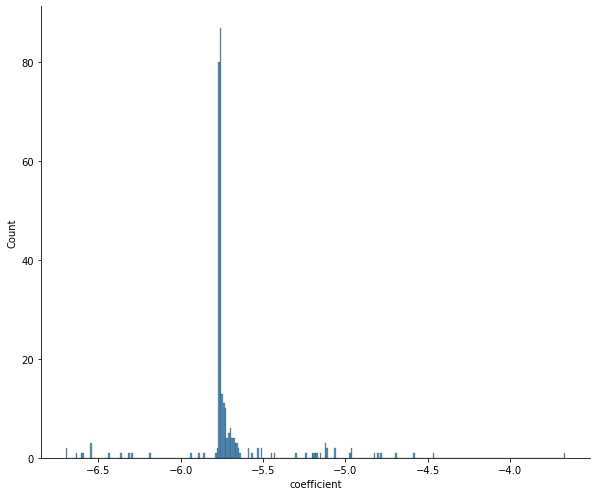

In [4]:
sns.displot(words_coeffs['coefficient'],height=7,aspect=1.2)    #plotting histogram of coefficients generated by multinomial model
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.savefig('./images/coefficient_and_word_count.png')

All the coefficients are negative. Most occur within a very narrow range indicating there are few words that are large enough outliers to produce good signal. Let's take a quick look at the words with 10 largest and 10 smallest coefficients.

In [7]:
most_frequent_words_cvect=pd.concat([words_coeffs.head(10),words_coeffs.tail(10)])
most_frequent_words_cvect

,coefficient,word,scaled_coefficient
185,-6.696800,pcpartpicker com product,0.000000
42,-6.690343,com product,0.002129
197,-6.635339,product,0.020266
6,-6.598105,atx,0.032544
75,-6.590178,gb,0.035158
82,-6.547080,https pcpartpicker com,0.049369
81,-6.547080,https pcpartpicker,0.049369
143,-6.545949,motherboard,0.049742
184,-6.430606,pcpartpicker com,0.087775
183,-6.362319,pcpartpicker,0.110292


We need to read in the file with combined data from /r/buildapc and /r/buildapcforme.

In [8]:
combined_data=pd.read_csv('./data/combined_data.csv')

In [9]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29256 entries, 0 to 29255
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   29256 non-null  object
 1   subreddit  29256 non-null  object
dtypes: object(2)
memory usage: 457.2+ KB


In [10]:
combined_data

,selftext,subreddit
0,Not sure if this is the correct sub or not but...,buildapc
1,"Hello,I need as much help as I can get because...",buildapc
2,I have my build but can't pick a motherboard. ...,buildapc
3,I'm getting my friends old RX580 after he upgr...,buildapc
4,[deleted],buildapc
...,...,...
29251,[removed],buildapcforme
29252,[removed],buildapcforme
29253,&gt;**What will you be doing with this PC? Be ...,buildapcforme
29254,&gt;&gt;**What will you be doing with this PC?...,buildapcforme


Term frequency-inverse document frequency (more commonly known as TF-IDF) reflects the importance of a word in a collection. It captures the importance of words better than raw count. Let's use TfidVectorizer to vectorize comments in the combined_data dataframe and study the distribution of TF-IDF scores.

In [12]:
vectorizer=TfidfVectorizer(stop_words=stop_words,max_features=500)    #selecting the 500 highest frequency words
data_combined=vectorizer.fit_transform(combined_data['selftext']).toarray()
df_tfidf_combined=pd.DataFrame(data_combined,columns=vectorizer.get_feature_names())
top_words_tf = {}
for i in df_tfidf_combined.columns:
    top_words_tf[i] =  df_tfidf_combined[i].sum()
    
most_freq_tf_combined = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

number of words listed in the dataframe: 500 
95th percentile of TF-IDF scores corresponds to: 801.3175668478639


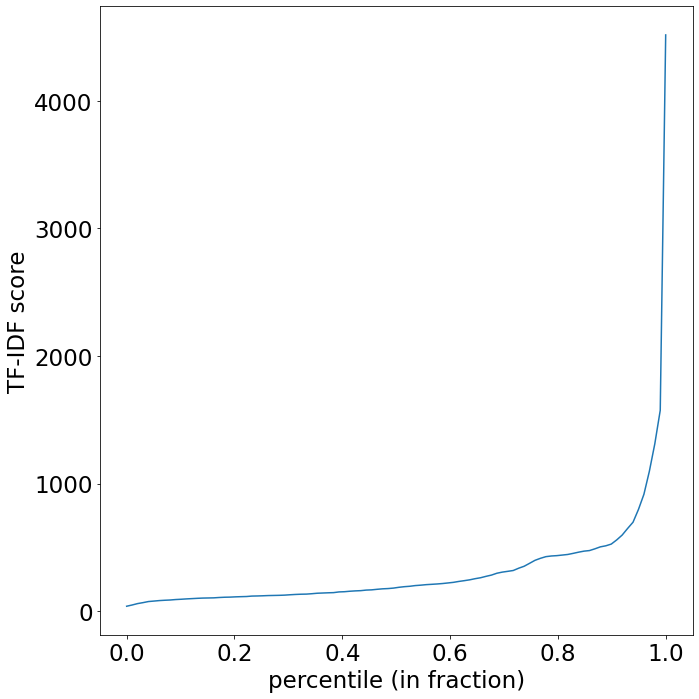

In [34]:
print('number of words listed in the dataframe:', most_freq_tf_combined[1].count(),'\n95th percentile of TF-IDF scores corresponds to:',most_freq_tf_combined[1].quantile(0.95))
plt.plot(most_freq_tf_combined[1].quantile(np.linspace(0.00,1.0,100)))
plt.xlabel('percentile (in fraction)')
plt.ylabel('TF-IDF score')
plt.tight_layout()
plt.savefig('./images/tfidf_percentile_score.png')

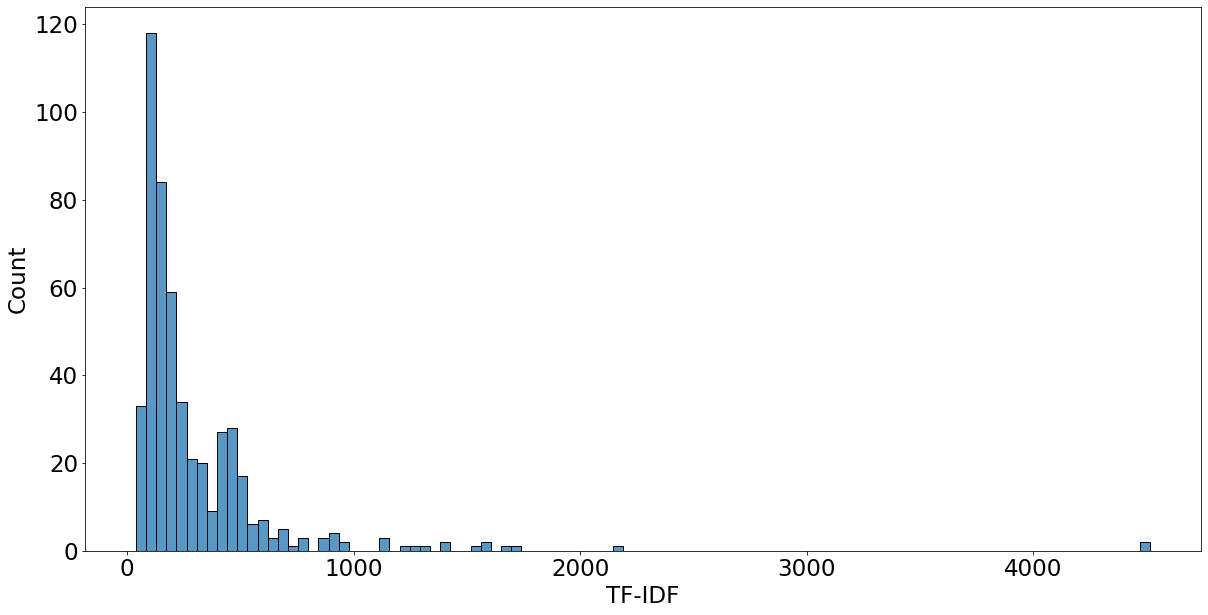

In [67]:
fig,ax=plt.subplots()
sns.histplot(most_freq_tf_combined[1],bins=100,ax=ax) #histogram of TF-IDF scores.
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.xlabel('TF-IDF')
plt.rcParams.update(params)

Next, we can sort the words in descending order of TF-IDF and plot them in that order.

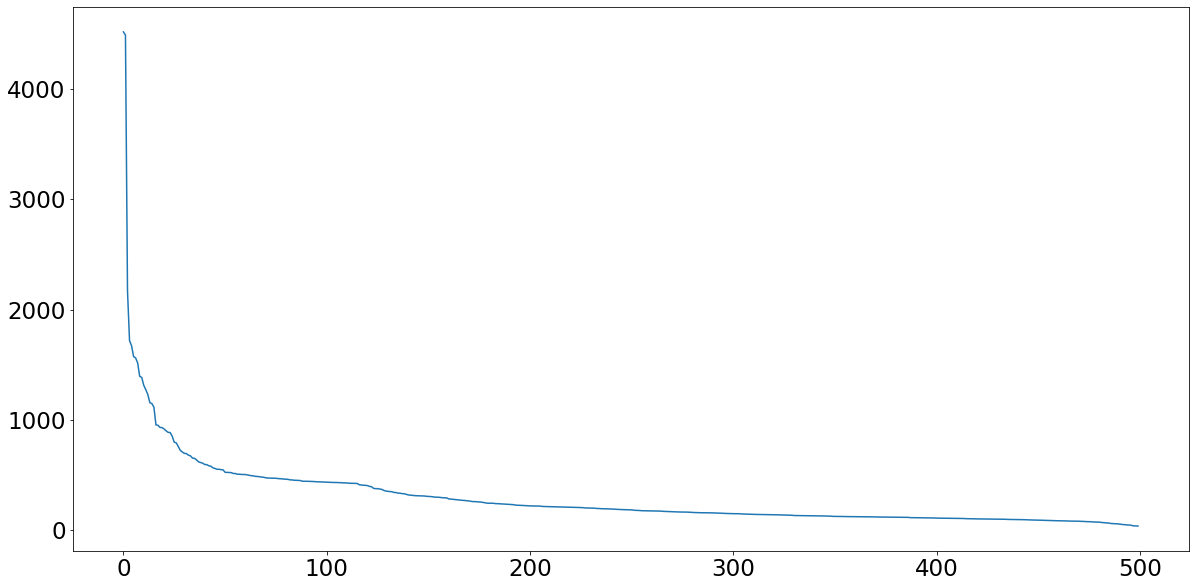

In [62]:
plt.plot(most_freq_tf_combined[1])

In [76]:
most_freq_tf_combined.sort_values(by=[1],ascending=False,inplace=True)
print('array of 100 most important words according to TF-IDF:','\n',np.array(most_freq_tf_combined[0])[:100])

array of 100 most important words according to TF-IDF: 
 ['removed' 'gt' 'need' 'specific' 'pc' 'tower' 'parts' 'budget' 'build'
 'monitor' 'included' 'want' 'like' 'mouse' 'keyboard' 'pcpartpicker'
 'case' 'overclocking' 'reusing' 'games' 'cpu' 'preference' 'amp' 'just'
 'ssd' 'gpu' 'gaming' 'windows' 'list' 'new' 'don' 'know' 'using' 'x200b'
 'motherboard' 'buy' 'possible' 'building' 'ram' 'storage' 'yes'
 'microcenter' 'good' 'looking' 'right' 'os' 'product' 've' 'plan' 'mid'
 'buying' 'appreciated' 'wifi' 'ryzen' 'doing' 'week' 'access' 'help'
 'line' 'use' 'led' 'components' 'card' 'setup' 'really' 'window' 'power'
 'copy' 'lighting' 'away' 'interested' 'support' 'large' 'state' 'size'
 'thanks' 'programs' 'color' 'fans' 'include' 'today' 'upgrade' 'means'
 'maximum' 'including' 'theme' 'itx' 'purchasing' 'preferences' 'country'
 'exactly' 'shipping' 'gb' 'location' 'colors' 'date' 'note' 'particular'
 'microatx' 'taxes']


We can vectorize any individual comment and peaks will be characteristic of that comment. The main idea behind this work is that this data can be used by a machine learning algorithm to correctly classify the origin of the comment.  The model takes in raw characteristics data, but as example, let's plot this for comment# 25240 in combined_data to illustrate the process.

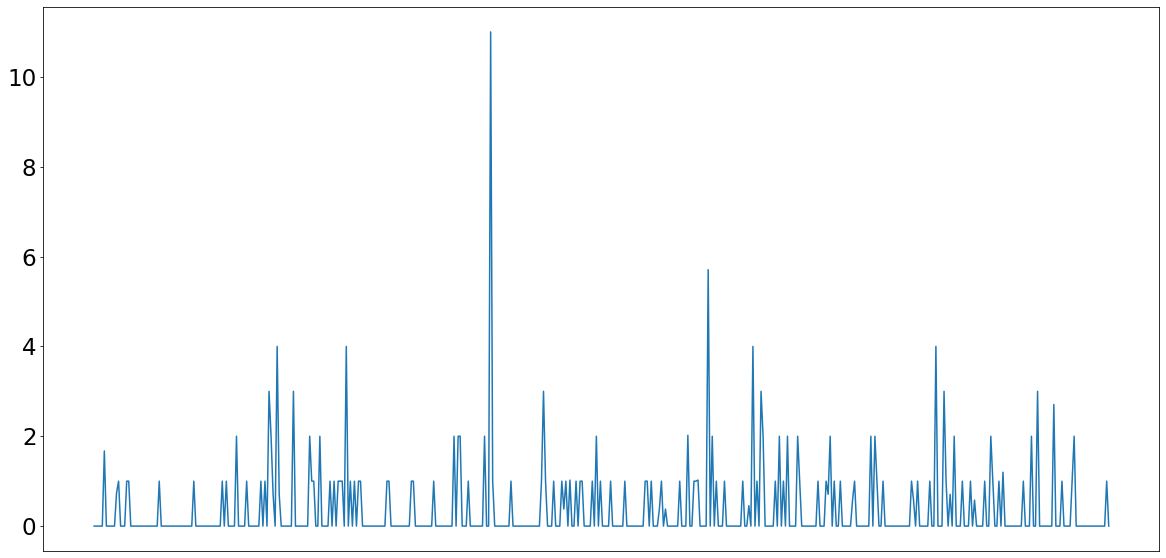

In [68]:
example_data=vectorizer.transform(combined_data['selftext'][25240].split()).toarray()
random_comment_vectorized=pd.DataFrame(example_data,columns=vectorizer.get_feature_names())
plt.plot(random_comment_vectorized.sum())
plt.xticks(rotation='vertical');
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    labelbottom=False) 
plt.savefig('characteristic_25240.png')

We can create separate lists of most important for each subreddit and feed that information to a classification algorithm. That's what I do next. Because of their strong signal indicating originating subreddit, I call the top 10 words from each list (excluding any words in common) as 'fingerprint words'.

Let's take a look at what those words are.

In [18]:
vectorizer=TfidfVectorizer(stop_words=stop_words,max_features=500,ngram_range=(1,3))
data_buildapc=vectorizer.fit_transform(combined_data[combined_data['subreddit']=='buildapc']['selftext']).toarray()
df_tfidf_buildapc=pd.DataFrame(data_buildapc,columns=vectorizer.get_feature_names())
top_words_tf = {}
for i in df_tfidf_buildapc.columns:
    top_words_tf[i] =  df_tfidf_buildapc[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf_buildapc = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))

In [19]:
most_freq_tf_buildapc.sort_values(by=[1],ascending=False,inplace=True)
most_freq_tf_buildapc

,0,1
0,pc,835.609297
1,pcpartpicker,743.816461
2,build,629.779222
3,just,593.348289
4,cpu,568.041504
...,...,...
495,gb 16,21.310782
496,gb 16 gb,21.310782
497,am4 motherboard pcpartpicker,20.856771
498,amazon storage,20.544284


<BarContainer object of 25 artists>

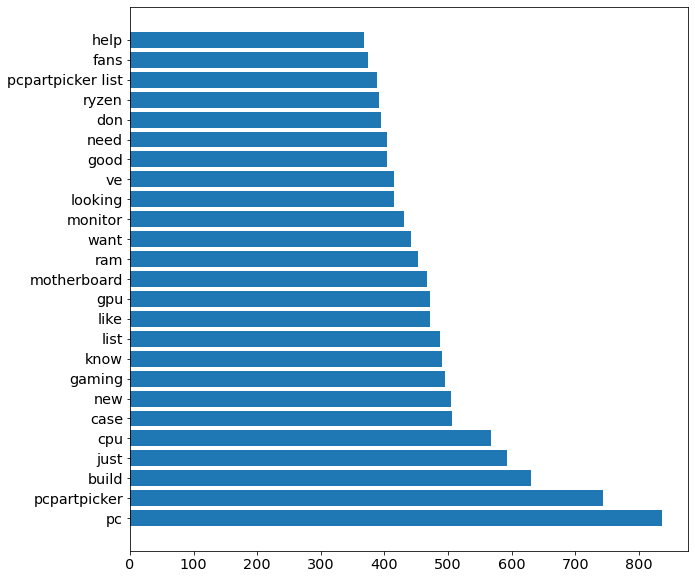

In [20]:
plt.barh(most_freq_tf_buildapc[0][0:25],most_freq_tf_buildapc[1][0:25])

In [21]:
vectorizer=TfidfVectorizer(stop_words=stop_words,max_features=500)
data_buildapcforme=vectorizer.fit_transform(combined_data[combined_data['subreddit']=='buildapcforme']['selftext']).toarray()
df_tfidf_buildapcforme=pd.DataFrame(data_buildapcforme,columns=vectorizer.get_feature_names())
top_words_tf = {}
for i in df_tfidf_buildapcforme.columns:
    top_words_tf[i] =  df_tfidf_buildapcforme[i].sum()
    
# top_words to dataframe sorted by highest occurance
most_freq_tf_buildapcforme = pd.DataFrame(sorted(top_words_tf.items(), key = lambda x: x[1], reverse = True))
most_freq_tf_buildapcforme.sort_values(by=[1],ascending=False,inplace=True)
most_freq_tf_buildapcforme

,0,1
0,removed,4334.283739
1,gt,3825.472466
2,need,1766.704743
3,specific,1441.808200
4,tower,1340.207134
...,...,...
495,modular,26.738709
496,am4,24.740029
497,fully,22.950811
498,certified,22.178998


<BarContainer object of 25 artists>

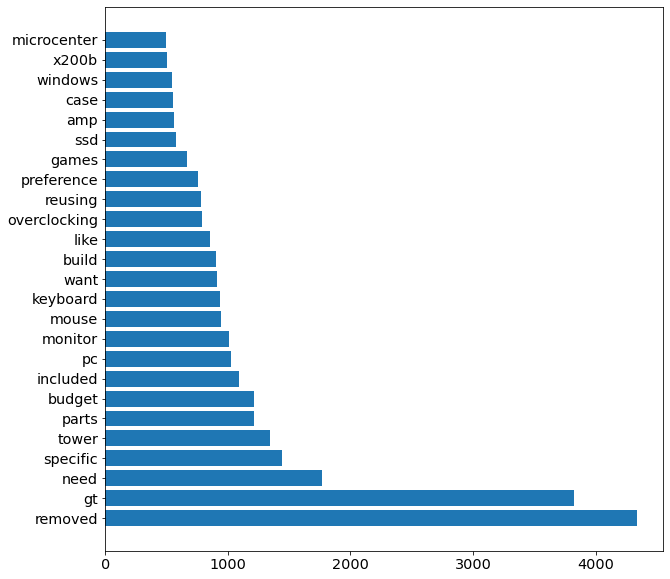

In [22]:
plt.barh(most_freq_tf_buildapcforme[0][0:25],most_freq_tf_buildapcforme[1][0:25])

In [23]:
fingerprint_words=set(list(most_freq_tf_buildapc[0][0:10])+list(most_freq_tf_buildapcforme[0][0:10]))
fingerprint_words

{'budget',
 'build',
 'case',
 'cpu',
 'gaming',
 'gt',
 'included',
 'just',
 'know',
 'list',
 'monitor',
 'need',
 'new',
 'parts',
 'pc',
 'pcpartpicker',
 'removed',
 'specific',
 'tower'}

In [24]:
df_fingerprint_words=pd.concat([most_freq_tf_buildapc[0:10],most_freq_tf_buildapcforme[0:10]])

In [25]:
#np.array(df_fingerprint_words.iloc[11:20][0])

In [26]:
common_words=list(set(most_freq_tf_buildapc[0][0:10]) & set(most_freq_tf_buildapcforme[0][0:10]))
common_words

['pc']

In [27]:
df_unique_fingerprint_words=df_fingerprint_words[~df_fingerprint_words[0].isin(common_words)]

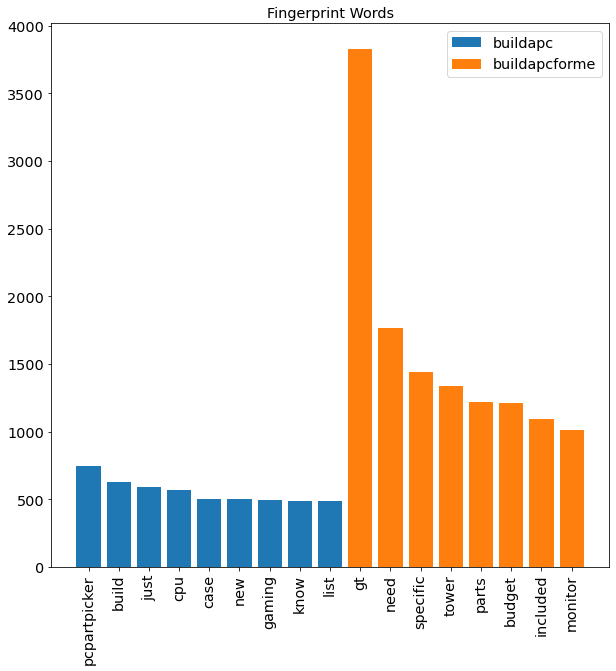

In [28]:
ax=plt.bar(df_unique_fingerprint_words[0][0:9],df_unique_fingerprint_words[1][0:9])
ax.set_label('buildapc')
plt.legend()
ax=plt.bar(df_unique_fingerprint_words[0][10:],df_unique_fingerprint_words[1][10:])
ax.set_label('buildapcforme')
plt.xticks(rotation='vertical')
plt.title('Fingerprint Words')
plt.legend()
plt.savefig('./images/fingerprint_words.png')

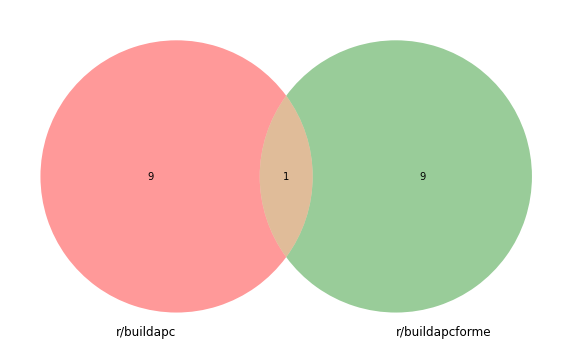

In [29]:
venn2(subsets = (9,9,1), set_labels = ('r/buildapc', 'r/buildapcforme'))
plt.rcParams.update({'font.size': 16})
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

Finally, we need to how how many features to select for the model. The process I followed is easier to illustrate than to describe with words. Let's take a look at the plot below.

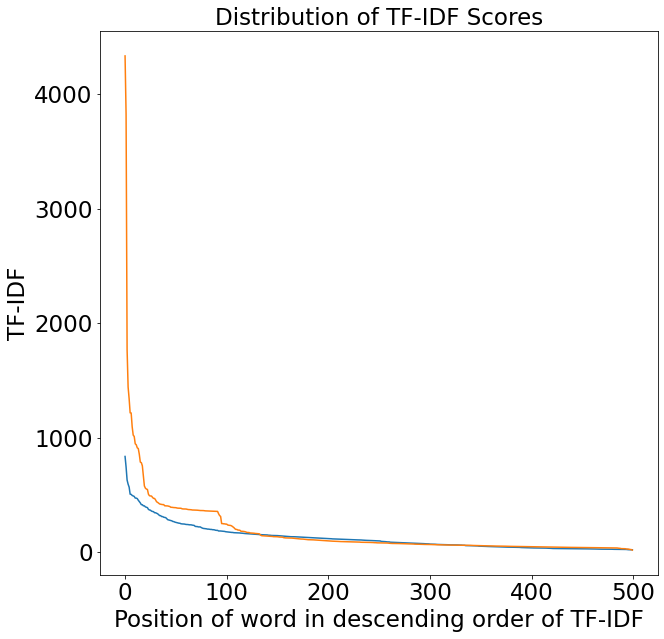

In [30]:
plt.plot(np.array(most_freq_tf_buildapc[1]))
plt.plot(np.array(most_freq_tf_buildapcforme[1]))
plt.xlabel('Position of word in descending order of TF-IDF')
plt.ylabel('TF-IDF')
plt.title('Distribution of TF-IDF Scores')
plt.savefig('./images/distribution of tf-idf.png')

There are approximately 130-140 words in each subreddit with high values TD-IDF values and different distribution. These may or may not be the same words. But assuming the most conservative case, where the two sets of words are mutually exclusive, we have 260-280 words which will provide strong signal indicating where originating subreddit. I chose 285 words as the number of features based on this line of argument.